In [4]:
import tensorflow as tf 
import numpy as np 
from src import layers, utils, models
import matplotlib.pyplot as plt 
from importlib import reload 
reload(layers)
reload(models)

<module 'src.models' from '/mnt/a/Users/Claudio/Documents/PROJECTS/Infini-Attention/src/models.py'>

In [22]:
B = 30  # Batch Size
C = 50  # Context Length
I = 2  # Input dim
D = 2  # Output dim
H = 3  # Heads/Layers
N = 6  # Segments
T = (C+1)*N  # Total series length

model = models.InfiniAttentionModel(dims=D, heads=H, context_length=C, positional_encoding=False)
model.compile("adam", "mse")

li = tf.keras.Input(shape=(None, I))
cells = [tf.keras.layers.LSTMCell(units=5, activation="elu") for _ in range(H-1)]
cells.append(tf.keras.layers.LSTMCell(units=2, activation="linear"))
lstm = tf.keras.layers.RNN(
    tf.keras.layers.StackedRNNCells(cells),
    return_sequences=True, return_state=False)
lo = lstm(li)
lstm_model = tf.keras.models.Model(li, lo)
lstm_model.compile("adam", "mse")

In [23]:
xt = utils.generate_sin(length=T, samples=B)
xt = tf.transpose(xt, (2, 0, 1))

x_in = []
for t in range(N):
    x_in.append(xt[:, t*(C+1):((t+1)*(C+1))][:, None, :, :])
x_in = tf.concat(x_in, axis=1)
x_in = tf.cast(x_in, tf.float32)

In [26]:
epochs = 800

history = model.fit(x_in[:, :, :-1], x_in[:, :, 1:], epochs=epochs, batch_size=50)
o = model(x_in[:, :, :-1])
oinf = o.numpy().reshape(B, -1, 2)

lstm_history = lstm_model.fit(xt[:, :-1], xt[:, 1:], epochs=epochs, batch_size=50)
olstm = lstm_model(xt)
olstm = olstm.numpy().reshape(B, -1, 2)

'lstm_history = lstm_model.fit(xt, xt, epochs=epochs, batch_size=50)\nolstm = lstm_model(xt)\nolstm = olstm.numpy().reshape(B, -1, 2)'

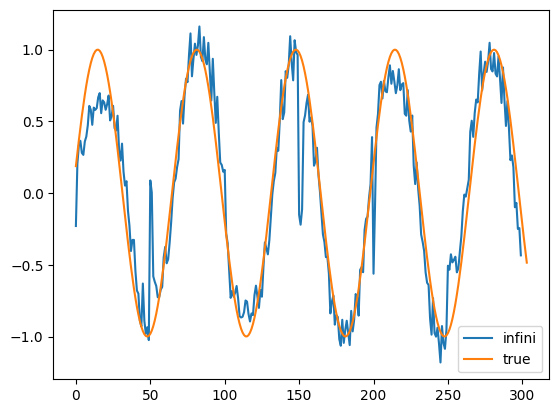

In [30]:
plt.plot(oinf[0, :, 0], label="infini")
#plt.plot(olstm[0, :, 0], label="lstm")
plt.plot(xt[0, 2:, 0], label="true")
plt.legend()    

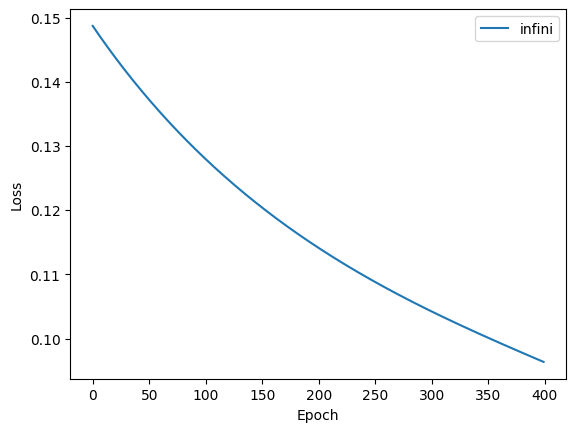

In [16]:
hi = history.history["loss"]
#hl = lstm_history.history["loss"]

plt.plot(hi, label="infini")
plt.plot(hl, label="lstm")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [14]:
from keras_nlp.api.layers import SinePositionEncoding

emb = tf.random.normal(shape=(100, 50, 10))
pos = SinePositionEncoding(max_wavelength=5)